In [177]:
import torch
from acq import UCB, EI, PI, KG, find_next_batch, optimize_acqf
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import core.kernel as kernel
from core.cigp_baseline import cigp



## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [178]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [179]:
input_dim = 1
num_initial_points = 20
torch.manual_seed(123)
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [180]:
kernel1 = kernel.ARDKernel(1)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = cigp(train_x,train_y)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [181]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [182]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,6,8,9,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [183]:
# Bayesian optimization loop
bounds = torch.tensor([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(200):
        optimizer.zero_grad()
        loss = model.negative_log_likelihood()
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    #batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = optimize_acqf(acq=ucb, raw_samples=50, bounds=bounds, f_best=0, num_restarts=30, options=None)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_var = model.forward(test_X)
            predictions.append((pred_mean, pred_var))


iter 0 nll:58.71626
iter 1 nll:58.61792
iter 2 nll:58.51961
iter 3 nll:58.42131
iter 4 nll:58.32303
iter 5 nll:58.22477
iter 6 nll:58.12653
iter 7 nll:58.02832
iter 8 nll:57.93012
iter 9 nll:57.83195
iter 10 nll:57.73380
iter 11 nll:57.63567
iter 12 nll:57.53757
iter 13 nll:57.43949
iter 14 nll:57.34144
iter 15 nll:57.24341
iter 16 nll:57.14540
iter 17 nll:57.04743
iter 18 nll:56.94948
iter 19 nll:56.85155
iter 20 nll:56.75366
iter 21 nll:56.65579
iter 22 nll:56.55795
iter 23 nll:56.46014
iter 24 nll:56.36236
iter 25 nll:56.26461
iter 26 nll:56.16689
iter 27 nll:56.06920
iter 28 nll:55.97155
iter 29 nll:55.87392
iter 30 nll:55.77633
iter 31 nll:55.67877
iter 32 nll:55.58124
iter 33 nll:55.48375
iter 34 nll:55.38629
iter 35 nll:55.28887
iter 36 nll:55.19148
iter 37 nll:55.09413
iter 38 nll:54.99681
iter 39 nll:54.89953
iter 40 nll:54.80229
iter 41 nll:54.70508
iter 42 nll:54.60791
iter 43 nll:54.51079
iter 44 nll:54.41369
iter 45 nll:54.31664
iter 46 nll:54.21963
iter 47 nll:54.12266
it

C:\Users\28772\AppData\Local\Temp\ipykernel_56276\3234116628.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_points = torch.tensor(batch_points).float()


iter 85 nll:33.75442
iter 86 nll:33.69078
iter 87 nll:33.62742
iter 88 nll:33.56435
iter 89 nll:33.50157
iter 90 nll:33.43908
iter 91 nll:33.37689
iter 92 nll:33.31499
iter 93 nll:33.25339
iter 94 nll:33.19208
iter 95 nll:33.13107
iter 96 nll:33.07035
iter 97 nll:33.00993
iter 98 nll:32.94982
iter 99 nll:32.89000
iter 100 nll:32.83048
iter 101 nll:32.77126
iter 102 nll:32.71235
iter 103 nll:32.65373
iter 104 nll:32.59542
iter 105 nll:32.53741
iter 106 nll:32.47971
iter 107 nll:32.42231
iter 108 nll:32.36521
iter 109 nll:32.30842
iter 110 nll:32.25193
iter 111 nll:32.19575
iter 112 nll:32.13988
iter 113 nll:32.08431
iter 114 nll:32.02904
iter 115 nll:31.97408
iter 116 nll:31.91943
iter 117 nll:31.86508
iter 118 nll:31.81103
iter 119 nll:31.75729
iter 120 nll:31.70386
iter 121 nll:31.65073
iter 122 nll:31.59790
iter 123 nll:31.54538
iter 124 nll:31.49315
iter 125 nll:31.44123
iter 126 nll:31.38961
iter 127 nll:31.33830
iter 128 nll:31.28728
iter 129 nll:31.23656
iter 130 nll:31.18613
ite

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

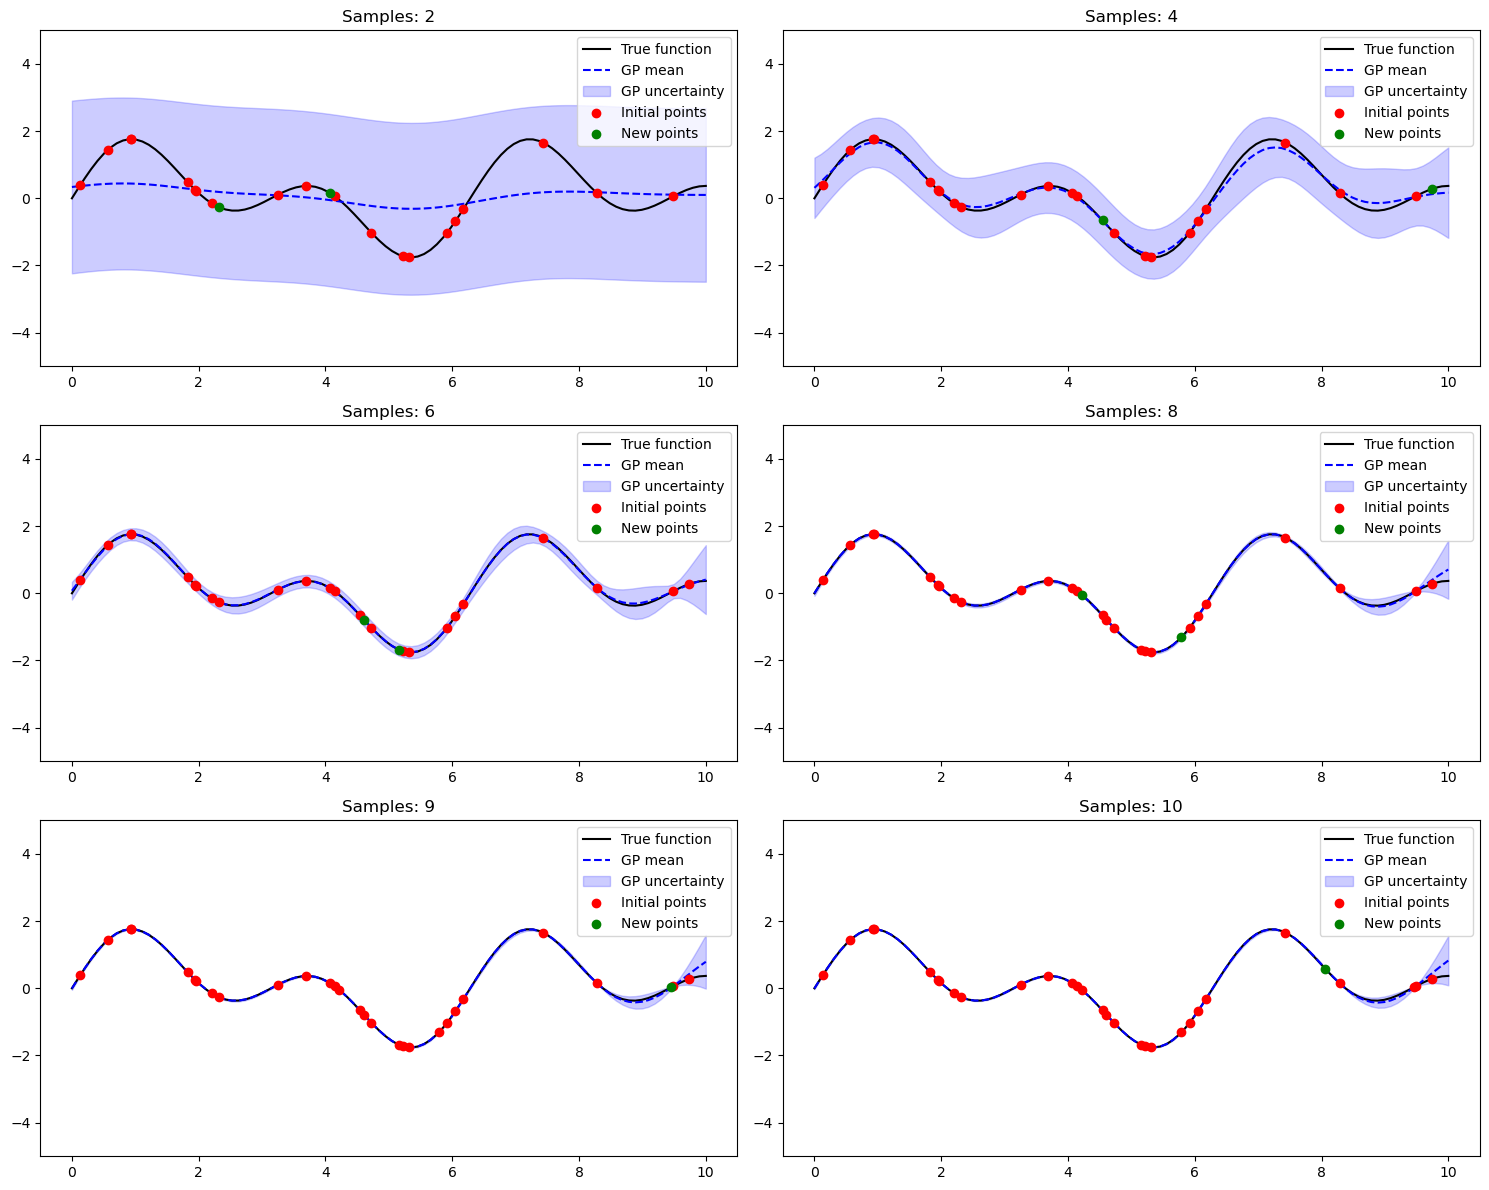

In [188]:
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_var) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    if i==0:
        num_new_points = key_iterations[i]
    else:
        num_new_points = key_iterations[i]-key_iterations[i-1]
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 1.96 * torch.sqrt(pred_var)).numpy().reshape(-1),
                     (pred_mean + 1.96 * torch.sqrt(pred_var)).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()

    # Initial observed points
    if i==0:
        plt.scatter(observed_x[:num_initial_points], observed_y[:num_initial_points], c='r', zorder=3, label='Initial points')
    else:
        plt.scatter(observed_x[:num_initial_points+key_iterations[i-1]], observed_y[:num_initial_points+key_iterations[i-1]], c='r', zorder=3, label='Initial points')
    # New points found by acquisition function
    if i==0:
        new_points_x = observed_x[num_initial_points:num_initial_points+key_iterations[i]]
        new_points_y = observed_y[num_initial_points:num_initial_points+key_iterations[i]]
    else:
        new_points_x = observed_x[num_initial_points+key_iterations[i-1]:num_initial_points+key_iterations[i]]
        new_points_y = observed_y[num_initial_points+key_iterations[i-1]:num_initial_points+key_iterations[i]]
    plt.scatter(new_points_x, new_points_y, c='g', zorder=3, label='New points')

    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()